# Model Training

## 1. Import Libraries

We import **pandas** and **numpy** for data handling, and **scikit‑learn** modules for preprocessing and splitting.

In [322]:
import pandas as pd
import numpy as np

In [323]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

---

## 2. Load the Dataset

Load the full ASSISTments CSV into a DataFrame.  

In [324]:
df = pd.read_csv('assistments_2009_2010.csv')

---

## 3. Initial Exploration

- **Shape** tells us total rows & columns.  
- **head()** previews the first 5 rows.  
- **info()** shows dtypes & non‑null counts.  
- **isnull().sum()** reveals missing values per column.

In [325]:
df.sample(10)

,order_id,assignment_id,user_id,assistment_id,problem_id,original,correct,attempt_count,ms_first_response_time,tutor_mode,answer_type,sequence_id,student_class_id,position,problem_set_type,base_sequence_id,list_skill_ids,list_skills,teacher_id,school_id
10526,20340418,257201,78441,32955,51084,1,0.0,1,341050.0,tutor,algebra,7215.0,12228.0,1.0,MasterySection,5942.0,NaN,NaN,48183.0,139.0
35166,20997869,255960,78126,47455,86023,1,1.0,1,193491.0,tutor,algebra,6939.0,12253.0,23.0,LinearSection,6939.0,NaN,NaN,46162.0,5056.0
950424,38223526,291290,96271,93527,174224,0,0.0,0,723.0,tutor,choose_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23111,20685359,260528,78975,25136,30511,1,1.0,1,140165.0,tutor,algebra,5008.0,12351.0,7.0,LinearSection,5008.0,NaN,NaN,42999.0,2770.0
114732,22293687,263280,71518,733,44194,0,1.0,1,420804.0,tutor,algebra,6958.0,12452.0,1.0,RandomChildOrderSection,6958.0,NaN,NaN,23097.0,76.0
916087,38175599,291451,96298,49013,87693,1,0.0,5,13126.0,tutor,algebra,6925.0,14415.0,60.0,MasterySection,6925.0,NaN,NaN,69274.0,5794.0
770898,33769407,279268,81889,24754,28971,1,0.0,3,37609.0,tutor,fill_in_1,4986.0,12542.0,70.0,RandomChildOrderSection,4986.0,16,Counting Methods,52667.0,2770.0
14480,20403266,261466,78132,23304,23304,1,0.0,2,20318.0,tutor,choose_1,7389.0,12253.0,4.0,LinearSection,7389.0,NaN,NaN,46162.0,5056.0
99682,22119615,263876,79519,25178,30576,1,1.0,1,104054.0,tutor,algebra,5008.0,12448.0,9.0,LinearSection,5008.0,NaN,NaN,14630.0,2770.0
300165,25825829,267936,78523,48127,86732,1,1.0,1,91228.0,test,algebra,8646.0,12262.0,1.0,RandomChildOrderSection,8646.0,280,Addition and Subtraction Fractions,46174.0,5056.0


In [326]:
print("Shape:", df.shape)
display(df.isnull().sum())

Shape: (1011079, 20)


,0
order_id,0
assignment_id,0
user_id,0
assistment_id,0
problem_id,0
original,0
correct,0
attempt_count,0
ms_first_response_time,125
tutor_mode,0


---

# Data Pre-Processing

In [327]:
# Map answer types to broader categories
answer_type_mapping = {
    'algebra': 'Problem-Solving',
    'choose_1': 'Knowledge-Based',
    'fill_in_1': 'Knowledge-Based',
    'choose_n': 'Strategic Reasoning',
    'open_response': 'Problem-Solving',
    'rank': 'Strategic Reasoning',
    'external': 'Knowledge-Based'  # assuming "external" is simple lookup questions
}

# Apply the mapping
df['answer_type'] = df['answer_type'].map(answer_type_mapping)
df['answer_type'].value_counts()

,count
answer_type,
Problem-Solving,580943
Knowledge-Based,423038
Strategic Reasoning,7098


In [328]:
# Normalizing the correct column
df['correct'] = df['correct'].apply(lambda x: 1 if x > 0.5 else 0)

In [329]:
# Filter the data to only include test or post mode and original equals 1
df_filtered = df.loc[(df['tutor_mode'] == 'test') | (df['tutor_mode'] == 'post')]
df_filtered = df_filtered.loc[df['original'] == 1]

In [330]:
# Drop the unneeded columns based on the list you provided
df_filtered = df_filtered.drop(columns=['order_id', 'assignment_id', 'assistment_id',
                                         'problem_id', 'ms_first_response_time',
                                        'sequence_id', 'student_class_id', 'original',
                                         'position', 'problem_set_type', 'base_sequence_id',
                                         'list_skill_ids', 'list_skills', 'teacher_id', 'school_id'])

In [331]:
# Aggregate the data by user_id and answer_type, summing the correct answers for each category
aggregated_df = df_filtered.groupby(['user_id', 'answer_type']).agg(
    correct_sum=('correct', 'sum')  # Sum of correct answers
).reset_index()

In [332]:
# Count the number of rows (questions answered) per user_id and answer_type
total_questions_per_category = df_filtered.groupby(['user_id', 'answer_type']).size().reset_index(name='total_questions')

# Merge the total questions into the aggregated data
aggregated_df = pd.merge(aggregated_df, total_questions_per_category, on=['user_id', 'answer_type'])

In [333]:
# Calculate the percentage of correct answers for each student and category
aggregated_df['correct_percentage'] = (aggregated_df['correct_sum'] / aggregated_df['total_questions']) * 100

In [334]:
aggregated_df

,user_id,answer_type,correct_sum,total_questions,correct_percentage
0,33121,Problem-Solving,20,20,100.000000
1,34037,Knowledge-Based,3,7,42.857143
2,34037,Problem-Solving,0,1,0.000000
3,53167,Knowledge-Based,32,39,82.051282
4,53167,Problem-Solving,17,29,58.620690
...,...,...,...,...,...
4046,96298,Knowledge-Based,23,30,76.666667
4047,96298,Problem-Solving,5,17,29.411765
4048,96298,Strategic Reasoning,0,1,0.000000
4049,96299,Knowledge-Based,15,18,83.333333


---

In [371]:
aggregated_df['average_correct_percentage'] = aggregated_df['correct_sum'] / aggregated_df['total_questions'] * 100

In [372]:
# Drop unnecessary columns
final_data = aggregated_df.drop(columns=['correct_sum', 'total_questions'])

In [373]:
final_data

,user_id,answer_type,correct_percentage,average_correct_percentage
0,33121,Problem-Solving,100.000000,100.000000
1,34037,Knowledge-Based,42.857143,42.857143
2,34037,Problem-Solving,0.000000,0.000000
3,53167,Knowledge-Based,82.051282,82.051282
4,53167,Problem-Solving,58.620690,58.620690
...,...,...,...,...
4046,96298,Knowledge-Based,76.666667,76.666667
4047,96298,Problem-Solving,29.411765,29.411765
4048,96298,Strategic Reasoning,0.000000,0.000000
4049,96299,Knowledge-Based,83.333333,83.333333


In [374]:
final_data_encoded = pd.get_dummies(final_data)

---

# Data Labeling

In [381]:
from sklearn.cluster import KMeans

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
final_data_encoded['cluster'] = kmeans.fit_predict(final_data_encoded[['average_correct_percentage']])

# Check the new clustering results
final_data_encoded.head()

,user_id,correct_percentage,average_correct_percentage,answer_type_Knowledge-Based,answer_type_Problem-Solving,answer_type_Strategic Reasoning,cluster
0,33121,100.000000,100.000000,False,True,False,0
1,34037,42.857143,42.857143,True,False,False,1
2,34037,0.000000,0.000000,False,True,False,2
3,53167,82.051282,82.051282,True,False,False,0
4,53167,58.620690,58.620690,False,True,False,1


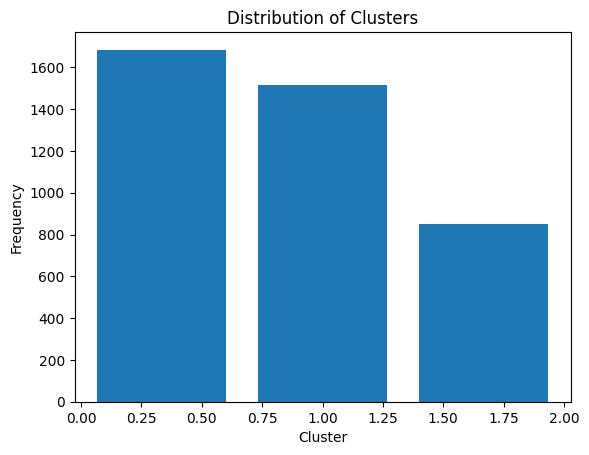

In [383]:
import matplotlib.pyplot as plt

plt.hist(final_data_encoded['cluster'], bins=3, rwidth=0.8) #added rwidth
plt.xlabel('Cluster')
plt.ylabel('Frequency')
plt.title('Distribution of Clusters')
plt.show()

---

# Model Training

In [386]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, f1_score, classification_report

In [387]:
X = final_data_encoded.drop(columns=['cluster'])
y = final_data_encoded['cluster']

In [388]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [389]:
rf = RandomForestClassifier(random_state=42)

rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [390]:
train_y_pred = rf.predict(X_train)
test_y_pred = rf.predict(X_test)

In [391]:
print("Train Recall:", recall_score(y_train, train_y_pred, average='weighted'))
print("Test Recall:", recall_score(y_test, test_y_pred, average='weighted'))

Train Recall: 1.0
Test Recall: 1.0


In [392]:
print("Train F1 Score:", f1_score(y_train, train_y_pred, average='weighted'))
print("Test F1 Score:", f1_score(y_test, test_y_pred, average='weighted'))

Train F1 Score: 1.0
Test F1 Score: 1.0


In [393]:
print(classification_report(y_train, train_y_pred))
print(classification_report(y_test, test_y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1346
           1       1.00      1.00      1.00      1216
           2       1.00      1.00      1.00       678

    accuracy                           1.00      3240
   macro avg       1.00      1.00      1.00      3240
weighted avg       1.00      1.00      1.00      3240

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       338
           1       1.00      1.00      1.00       299
           2       1.00      1.00      1.00       174

    accuracy                           1.00       811
   macro avg       1.00      1.00      1.00       811
weighted avg       1.00      1.00      1.00       811



---

# Model Saving

In [395]:
import joblib

joblib.dump(rf, 'rf_model.joblib')

['rf_model.joblib']